In [1]:
# Imports
import math

import numpy as np
import pandas as pd
import scipy.stats

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns

In [2]:
# Let's get some data
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')

In [3]:
# How is our data shaping up?
print('Our training dataset has {} rows and {} columns.'.format(train.shape[0], train.shape[1]))
print('Our test dataset has {} rows and {} columns.'.format(test.shape[0], test.shape[1]))

Our training dataset has 1460 rows and 81 columns.
Our test dataset has 1459 rows and 80 columns.


In [4]:

# Get info on our columns and data size
train.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

The cheapest house sold for $34,900 and the most expensive for $755,000
The average sales price is $180,921, while median is $163,000


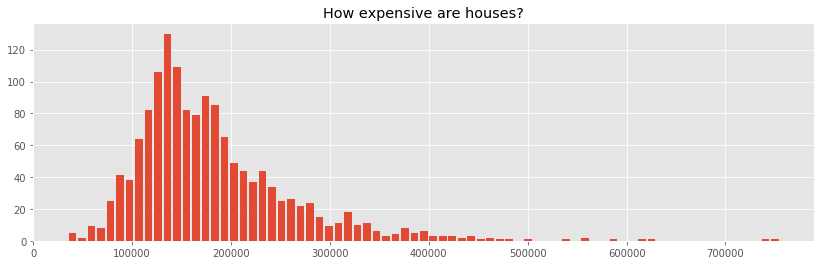

In [5]:
# How expensive are houses?
print('The cheapest house sold for ${:,.0f} and the most expensive for ${:,.0f}'.format(
    train.SalePrice.min(), train.SalePrice.max()))
print('The average sales price is ${:,.0f}, while median is ${:,.0f}'.format(
    train.SalePrice.mean(), train.SalePrice.median()))
train.SalePrice.hist(bins=75, rwidth=.8, figsize=(14,4))
plt.title('How expensive are houses?')
plt.show()

Oldest house built in 1872. Newest house built in 2010.


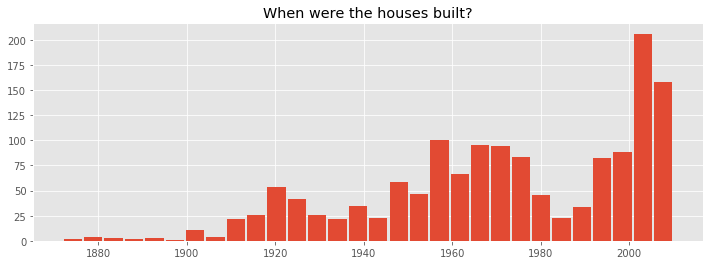

In [6]:


# When were the houses built?
print('Oldest house built in {}. Newest house built in {}.'.format(
    train.YearBuilt.min(), train.YearBuilt.max()))
train.YearBuilt.hist(bins=30, rwidth=.9, figsize=(12,4))
plt.title('When were the houses built?')
plt.show()

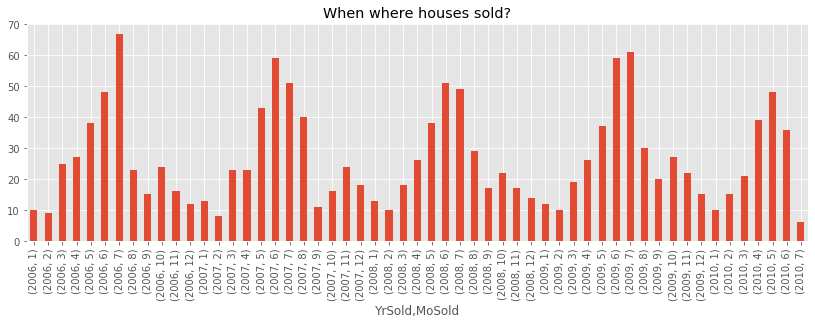

In [7]:
# When where houses sold?
train.groupby(['YrSold','MoSold']).Id.count().plot(kind='bar', figsize=(14,4))
plt.title('When where houses sold?')
plt.show()

Strong seasonality trend. Does this affect price?

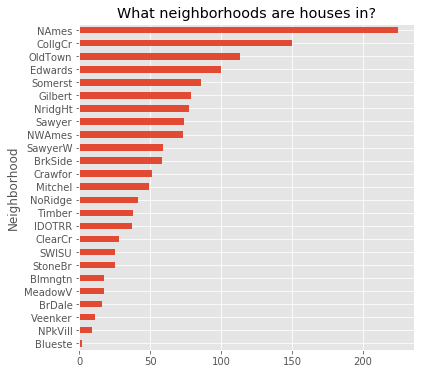

In [8]:
# Where are houses?
train.groupby('Neighborhood').Id.count().\
    sort_values().\
    plot(kind='barh', figsize=(6,6))
plt.title('What neighborhoods are houses in?')
plt.show()

Do neighborhoods with more sales correlate to higher prices?

The average house has 1,515 sq ft of space, the median 1,464 sq ft
The biggest house has 5,642 sq ft of space, the smallest 334 sq ft


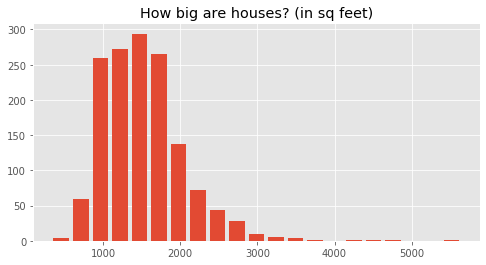

In [9]:
# How big are houses
print('The average house has {:,.0f} sq ft of space, the median {:,.0f} sq ft'.format(
    train.GrLivArea.mean(), train.GrLivArea.median()))
print('The biggest house has {:,.0f} sq ft of space, the smallest {:,.0f} sq ft'.format(
    train.GrLivArea.max(), train.GrLivArea.min()))
train.GrLivArea.hist(bins=21, rwidth=.8, figsize=(8,4))
plt.title('How big are houses? (in sq feet)')
plt.show()

The average lot is 0.24 acres, the median 0.22 acres
The biggest lot is 4.94 acres, the smallest 0.03 acres


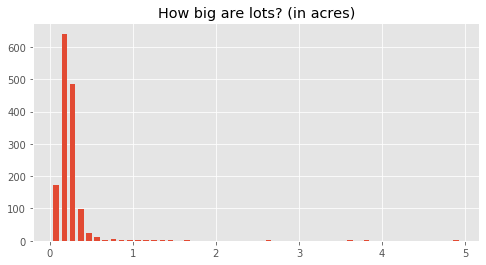

In [10]:
# How big are lots
sqft_to_acres = 43560.
print('The average lot is {:,.2f} acres, the median {:,.2f} acres'.format(
    train.LotArea.mean()/sqft_to_acres, train.LotArea.median()/sqft_to_acres))
print('The biggest lot is {:,.2f} acres, the smallest {:,.2f} acres'.format(
    train.LotArea.max()/sqft_to_acres, train.LotArea.min()/sqft_to_acres))
(train.LotArea/sqft_to_acres).hist(bins=50, rwidth=.7, figsize=(8,4))
plt.title('How big are lots? (in acres)')
plt.show()

## Univariate Analysis

In [11]:
def get_feature_groups():
    """ Returns a list of numerical and categorical features,
    excluding SalePrice and Id. """
    # Numerical Features
    num_features = train.select_dtypes(include=['int64','float64']).columns
    num_features = num_features.drop(['Id','SalePrice']) # drop ID and SalePrice

    # Categorical Features
    cat_features = train.select_dtypes(include=['object']).columns
    return list(num_features), list(cat_features)

num_features, cat_features = get_feature_groups()

In [12]:
len(cat_features)

43

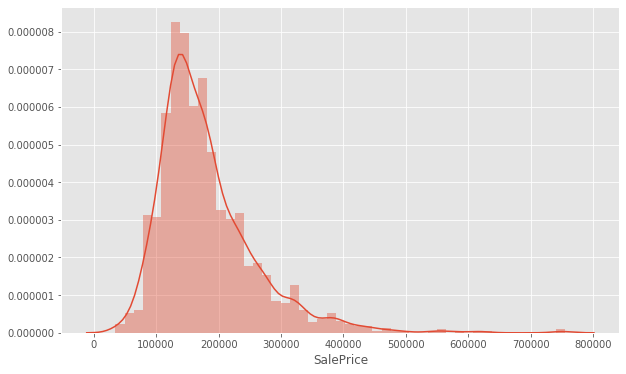

In [13]:
# Let's start with our dependent variable, SalePrice
plt.figure(figsize=(10,6))
sns.distplot(train.SalePrice)
plt.show()

In [14]:


print('Skew: {:.3f} | Kurtosis: {:.3f}'.format(
    train.SalePrice.skew(), train.SalePrice.kurtosis()))



Skew: 1.883 | Kurtosis: 6.536


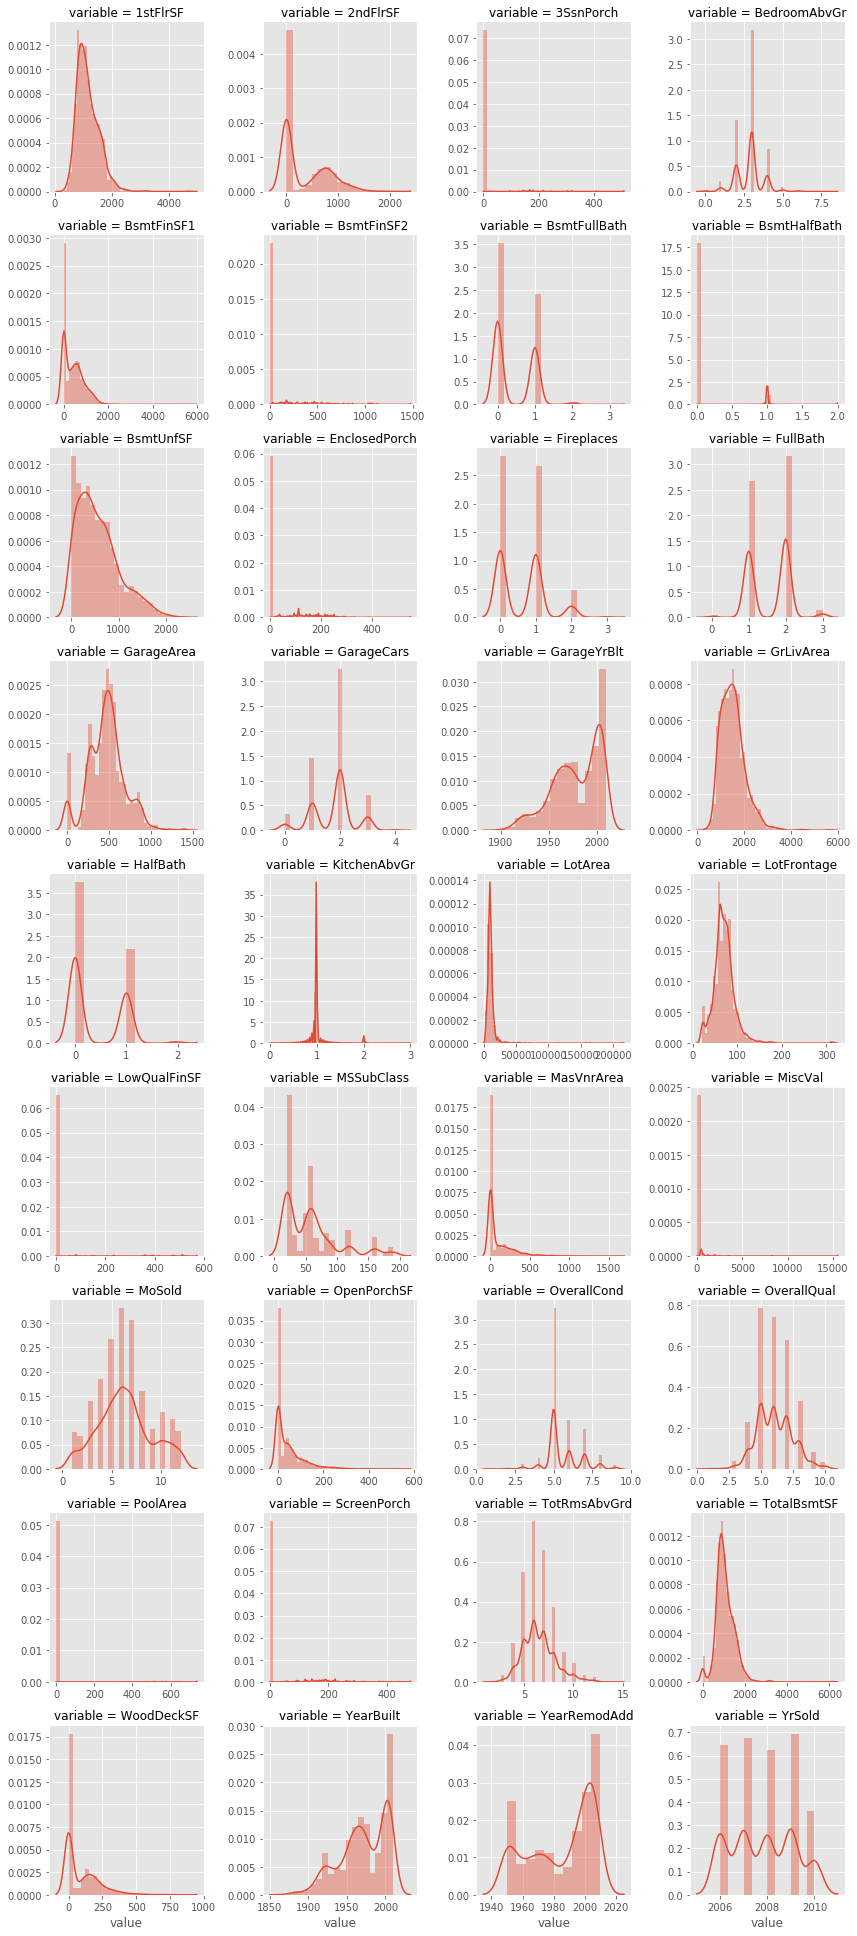

In [15]:


# Grid of distribution plots of all numerical features
f = pd.melt(train, value_vars=sorted(num_features))
g = sns.FacetGrid(f, col='variable', col_wrap=4, sharex=False, sharey=False)
g = g.map(sns.distplot, 'value')



We see a bunch of features that look positively skewed, similar to SalePrice. We'll want to log transform these, including: 

LotFrontage, LotArea, BsmtUnfSF, TotalBsmtSF, 1stFlrSF, GrLivAre, GarageArea

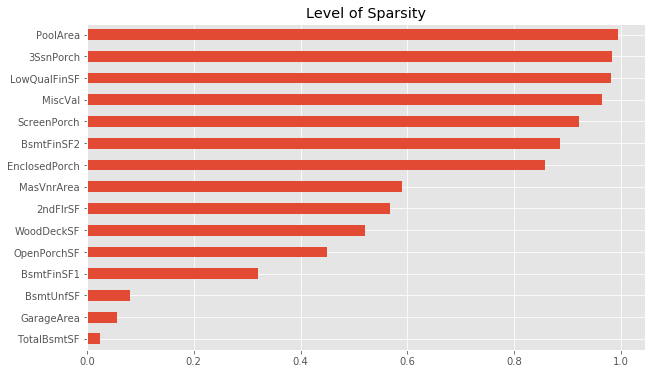

In [16]:


# Percentage of zero values
count_features = ['BsmtFullBath','BsmtHalfBath','FullBath','HalfBath','BedroomAbvGr',
                  'KitchenAbvGr','TotalRmsAbvGr','Fireplaces','GarageCars']
non_count_features = [f for f in num_features if f not in count_features]
sparse_features = (train[non_count_features] == 0).sum() / train.shape[0]
sparse_features[sparse_features > 0].\
    sort_values(ascending=True).\
    plot(kind='barh', figsize=(10,6))
plt.title('Level of Sparsity')
plt.show()



In [17]:


# First off, earlier we said we'll need to transform
# a couple features to categorical. Since we're looking 
# at categorical data here, let's go ahead and do that now
# so they are included in the analysis.
train['MSSubClass'] = train.MSSubClass.apply(lambda x: str(x))
train['MoSold'] = train.MoSold.apply(lambda x: str(x))
train['YrSold'] = train.YrSold.apply(lambda x: str(x))

# Update our list of numerical and categorical features
num_features, cat_features = get_feature_groups()



/usr/local/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:715: UserWarning: Using the countplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


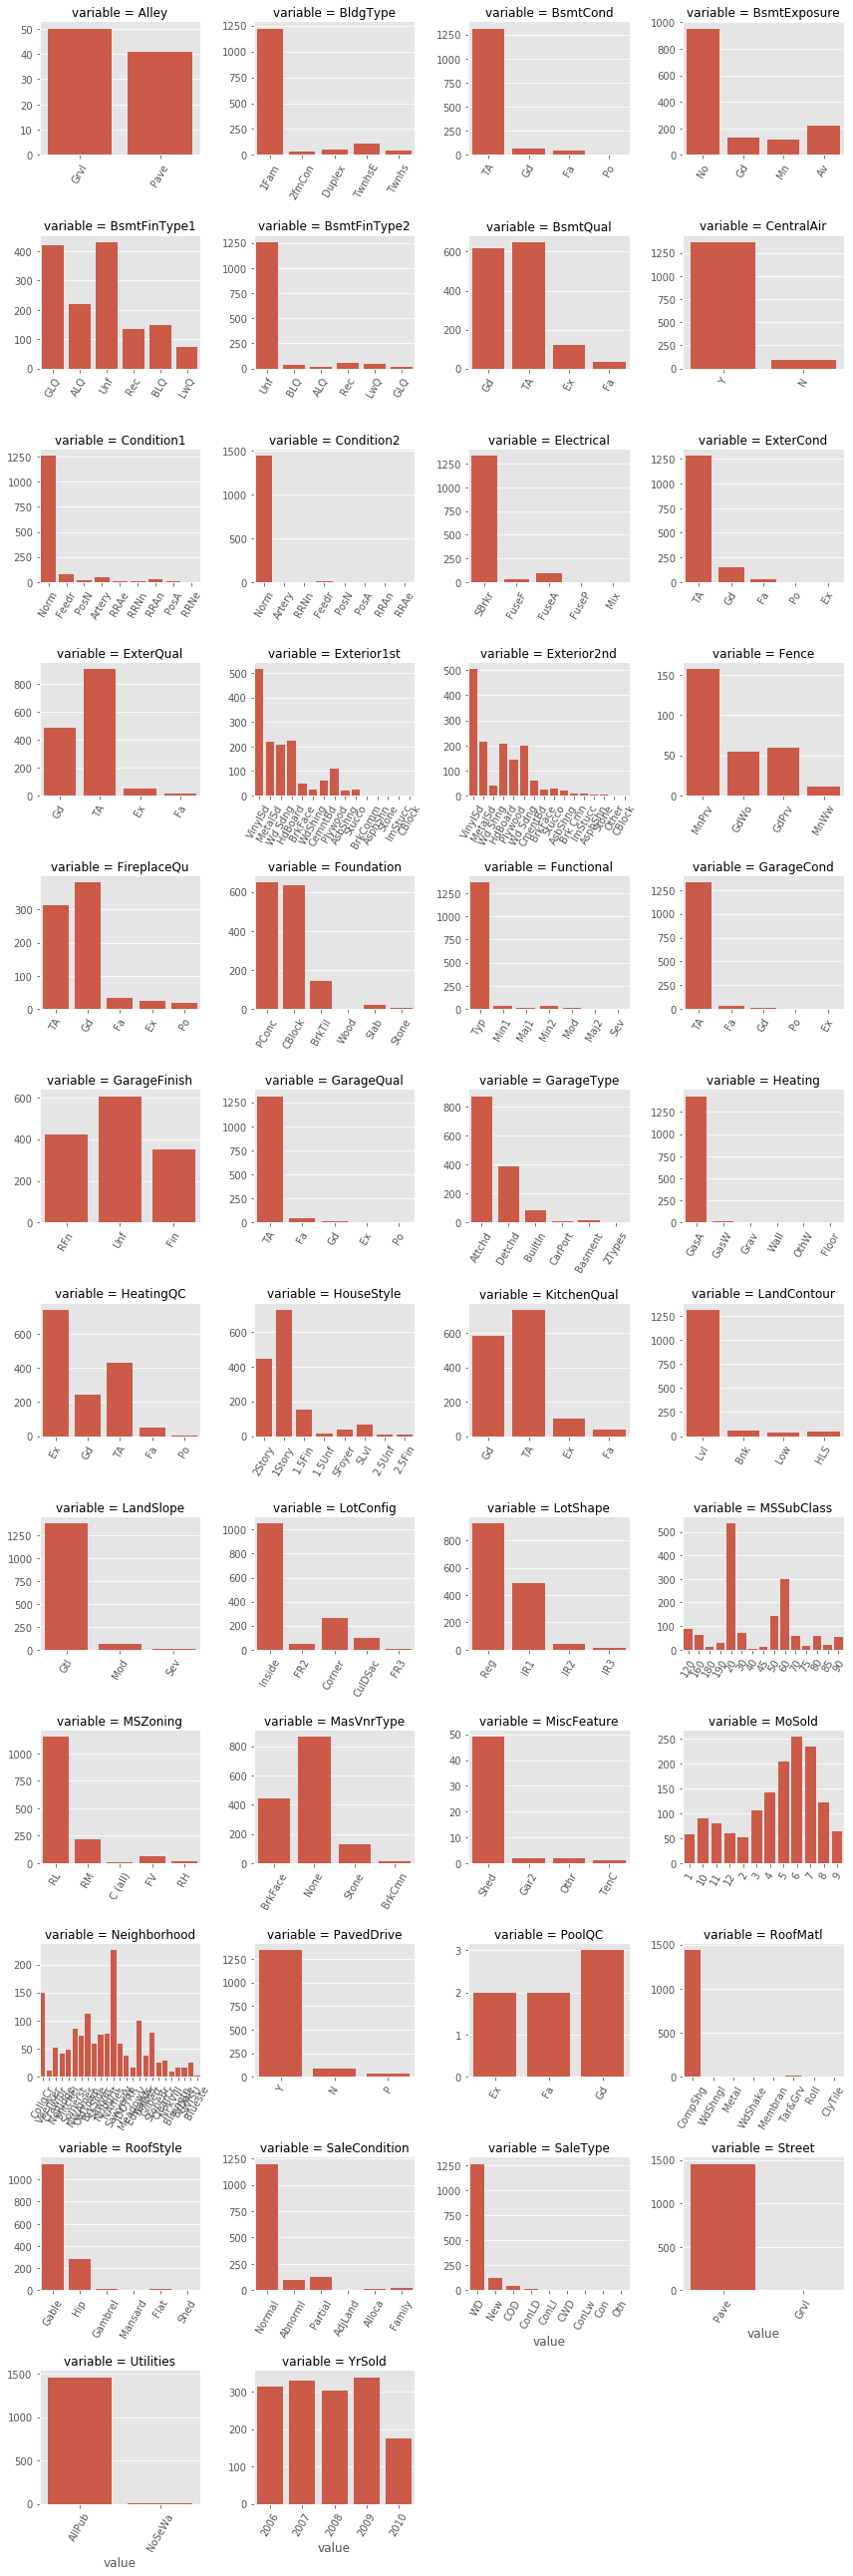

In [18]:


# Count plots of categorical features
f = pd.melt(train, value_vars=sorted(cat_features))
g = sns.FacetGrid(f, col='variable', col_wrap=4, sharex=False, sharey=False)
plt.xticks(rotation='vertical')
g = g.map(sns.countplot, 'value')
[plt.setp(ax.get_xticklabels(), rotation=60) for ax in g.axes.flat]
g.fig.tight_layout()
plt.show()



In [19]:
# Street
train.Street.replace({'Grvl': 1, 'Pave': 2},inplace=True)

# Alley
train.Alley.replace({'Grvl': 1, 'Pave': 2},inplace=True)

# LotShape
train.LotShape.replace({'Reg': 1, 'IR1': 2, 'IR2': 3,'IR3':4}, inplace=True)

# LandContour
train.LandContour.replace({'Lvl': 4, 'Bnk': 3, 'HLS': 2, 'Low':1}, inplace=True)

# Utilities
train.Utilities.replace({'AllPub': 4, 'NoSewr': 3, 'NoSeWa': 2, 'ELO':1}, inplace=True)

# Land Slope
train.LandSlope.replace({'Sev':1, 'Mod':2, 'Gtl':3}, inplace=True)

# Exterior Quality
train.ExterQual.replace({'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}, inplace=True)

# Exterior Condition
train.ExterCond.replace({'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}, inplace=True)

# Basement Quality
train.BsmtQual.replace({'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}, inplace=True)

# Basement Condition
train.BsmtCond.replace({'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}, inplace=True)

# Basement Exposure
train.BsmtExposure.replace({'No':1, 'Mn':2, 'Av':3, 'Gd':4}, inplace=True)

# Finished Basement 1 Rating
train.BsmtFinType1.replace({'Unf':1, 'LwQ':2, 'Rec':3, 'BLQ':4, 'ALQ':5, 'GLQ':6}, inplace=True)

# Finished Basement 2 Rating
train.BsmtFinType2.replace({'Unf':1, 'LwQ':2, 'Rec':3, 'BLQ':4, 'ALQ':5, 'GLQ':6}, inplace=True)

# Heating Quality and Condition
train.HeatingQC.replace({'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}, inplace=True)

# Kitchen Quality
train.KitchenQual.replace({'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}, inplace=True)

# Home functionality
train.Functional.replace({'Sal':1, 'Sev':2, 'Maj2':3, 'Maj1':4, 'Mod':5, 'Min2':6, 'Min1':7, 'Typ':8}, inplace=True)

# Fireplace Quality
train.FireplaceQu.replace({'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}, inplace=True)

# Garage Finish
train.GarageFinish.replace({'Unf':1, 'RFn':2, 'Fin':3}, inplace=True)

# Garage Quality
train.GarageQual.replace({'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}, inplace=True)

# Garage Condition
train.GarageCond.replace({'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}, inplace=True)

# Paved Driveway
train.PavedDrive.replace({'N':1, 'P':2, 'Y':3}, inplace=True)

# Pool Quality
train.PoolQC.replace({'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}, inplace=True)

# Fence
train.Fence.replace({'MnWw':2, 'GdWo':3, 'MnPrv':4, 'GdPrv':5}, inplace=True)

# We'll set all missing values in our newly converted features to 0
converted_features = ['Street','Alley','LotShape','LandContour','Utilities','LandSlope','ExterQual','ExterCond',
        'BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2','HeatingQC',
        'KitchenQual','Functional','FireplaceQu','GarageFinish','GarageQual',
        'GarageCond','PavedDrive','PoolQC','Fence']
train[converted_features] = train[converted_features].fillna(0)

In [20]:
num_features, cat_features = get_feature_groups()

In [21]:
cat_features

['MSSubClass',
 'MSZoning',
 'LotConfig',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'Foundation',
 'Heating',
 'CentralAir',
 'Electrical',
 'GarageType',
 'MiscFeature',
 'MoSold',
 'YrSold',
 'SaleType',
 'SaleCondition']

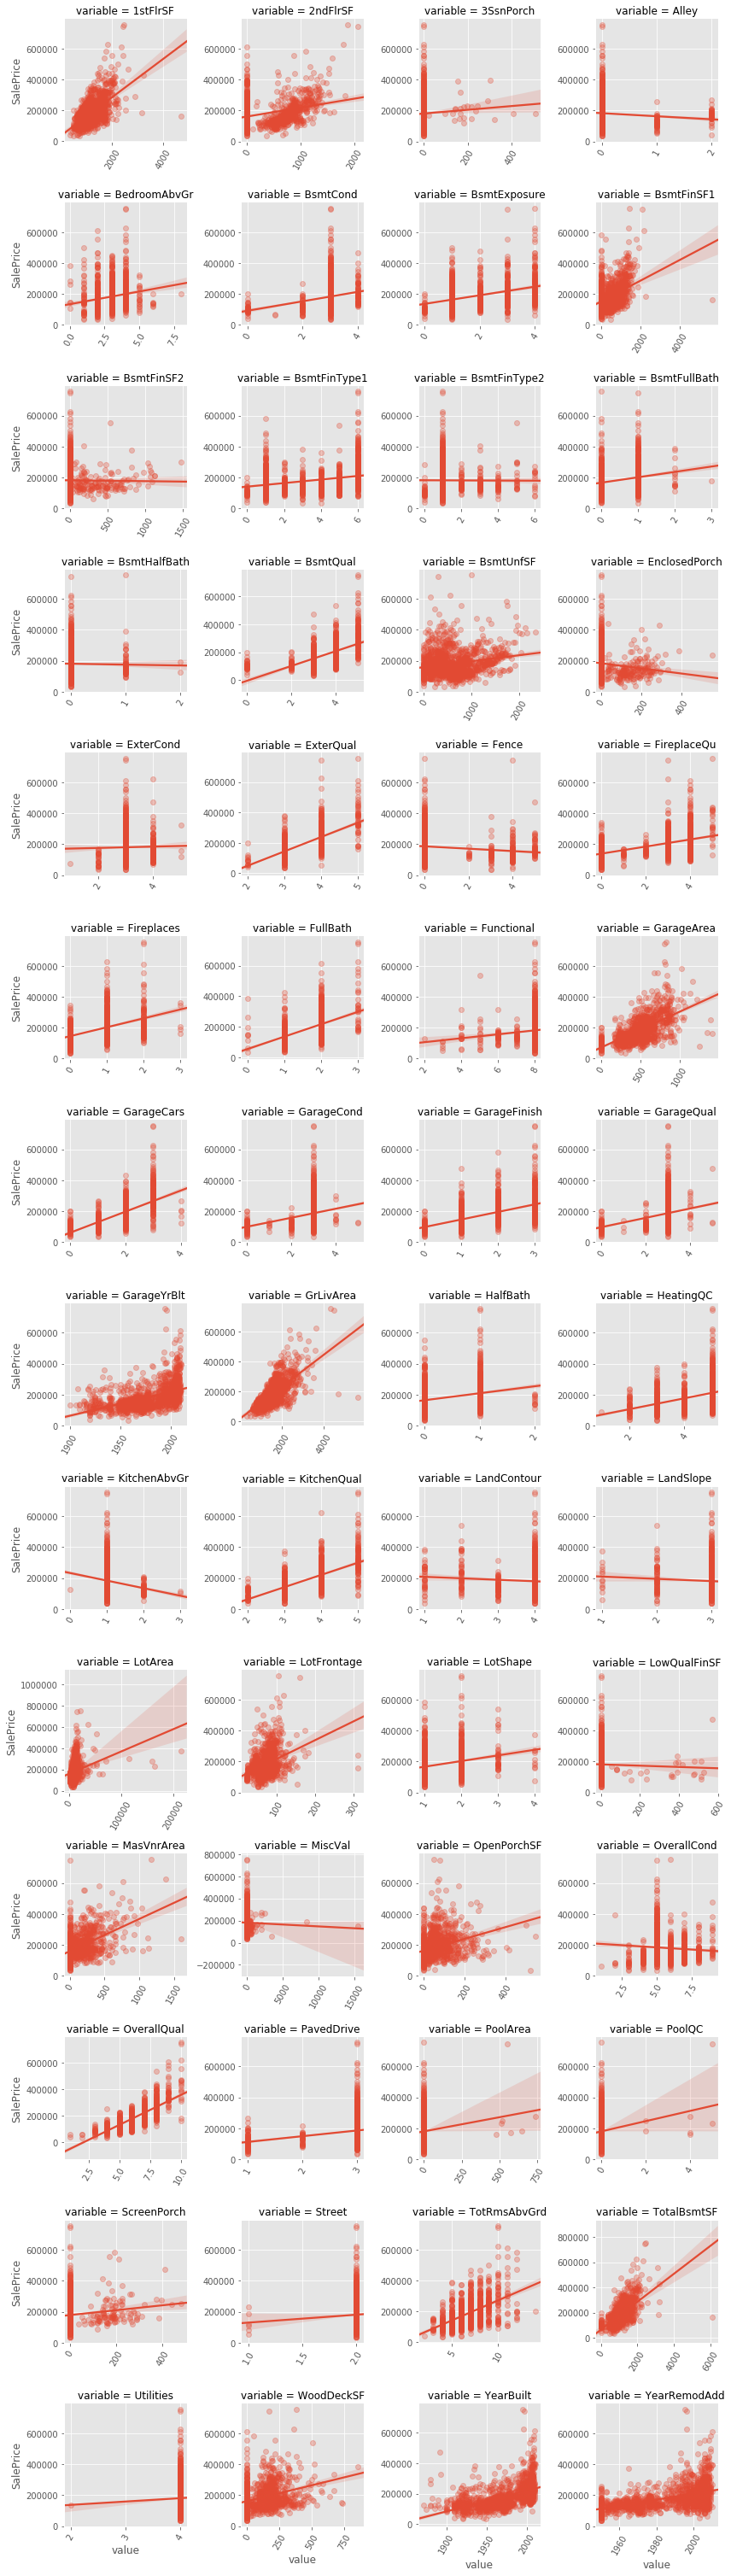

In [22]:
# Scatter plots of numerical features against SalePrice
f = pd.melt(train, id_vars=['SalePrice'], value_vars=sorted(num_features))
g = sns.FacetGrid(f, col='variable', col_wrap=4, sharex=False, sharey=False)
plt.xticks(rotation='vertical')
g = g.map(sns.regplot, 'value', 'SalePrice', scatter_kws={'alpha':0.3})
[plt.setp(ax.get_xticklabels(), rotation=60) for ax in g.axes.flat]
g.fig.tight_layout()
plt.show()


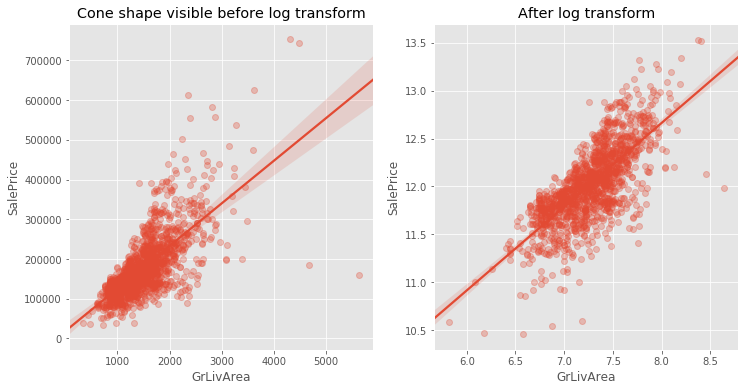

In [23]:
plt.figure(figsize=(12,6))
plt.subplot(121)
sns.regplot(train.GrLivArea, train.SalePrice, scatter_kws={'alpha':0.3})
plt.title('Cone shape visible before log transform')

plt.subplot(122)
sns.regplot(np.log1p(train.GrLivArea), np.log1p(train.SalePrice), scatter_kws={'alpha':0.3})
plt.title('After log transform')
plt.show()


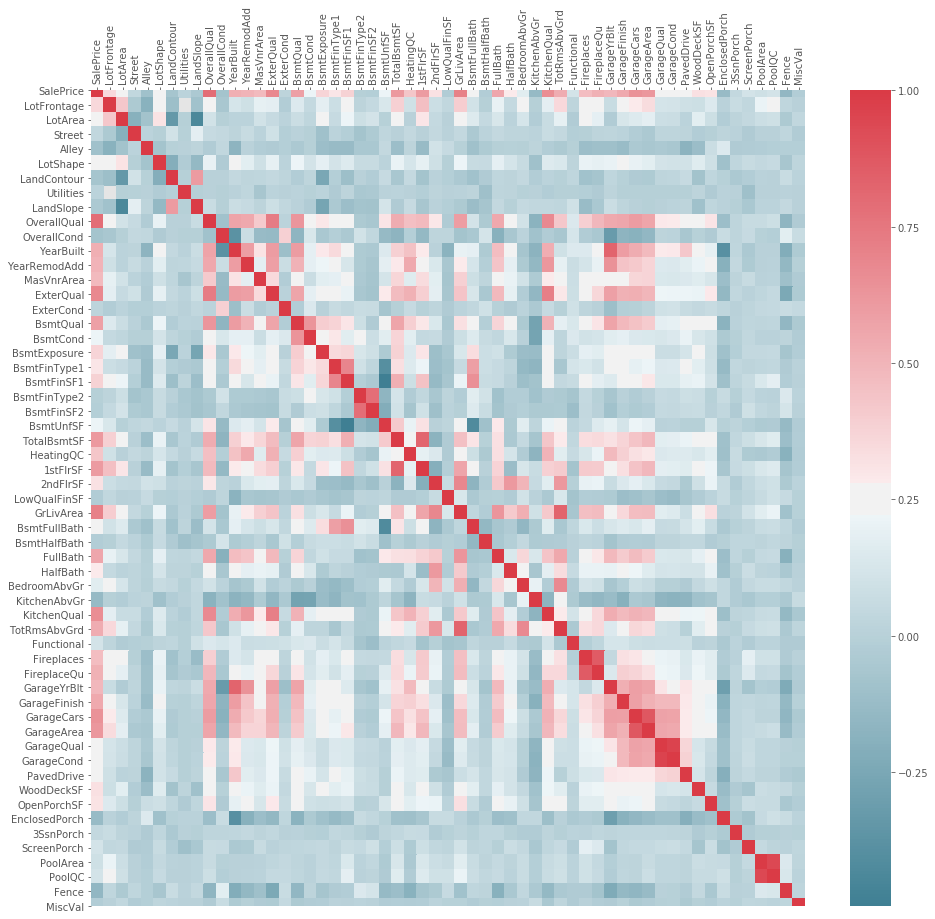

In [24]:


# Let's take a look at the correlation between numerical features
corr = train[['SalePrice'] + num_features].corr()
fig = plt.figure(figsize=(16,15))
ax = fig.add_subplot(111)
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, 
           xticklabels=corr.columns.values,
           yticklabels=corr.index.values,
           cmap=cmap)
ax.xaxis.tick_top()
plt.setp(ax.get_xticklabels(), rotation=90)
plt.show()



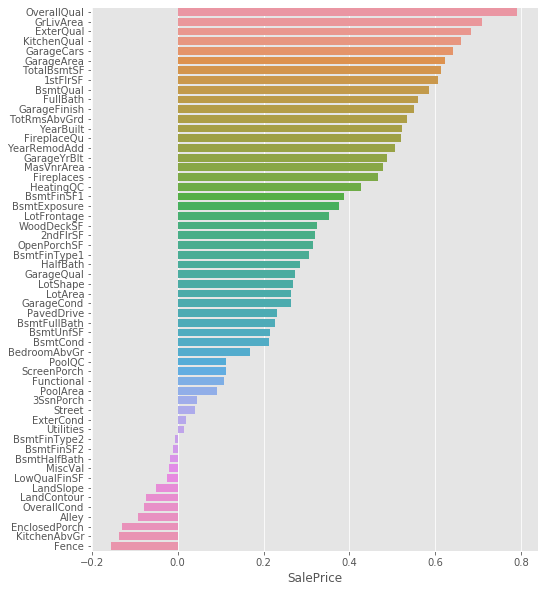

In [25]:
# Feature sorted by correlation to SalePrice, from positive to negative
corr = corr.sort_values('SalePrice', ascending=False)
plt.figure(figsize=(8,10))
sns.barplot( corr.SalePrice[1:], corr.index[1:], orient='h')
plt.show()


/usr/local/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/usr/local/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:715: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


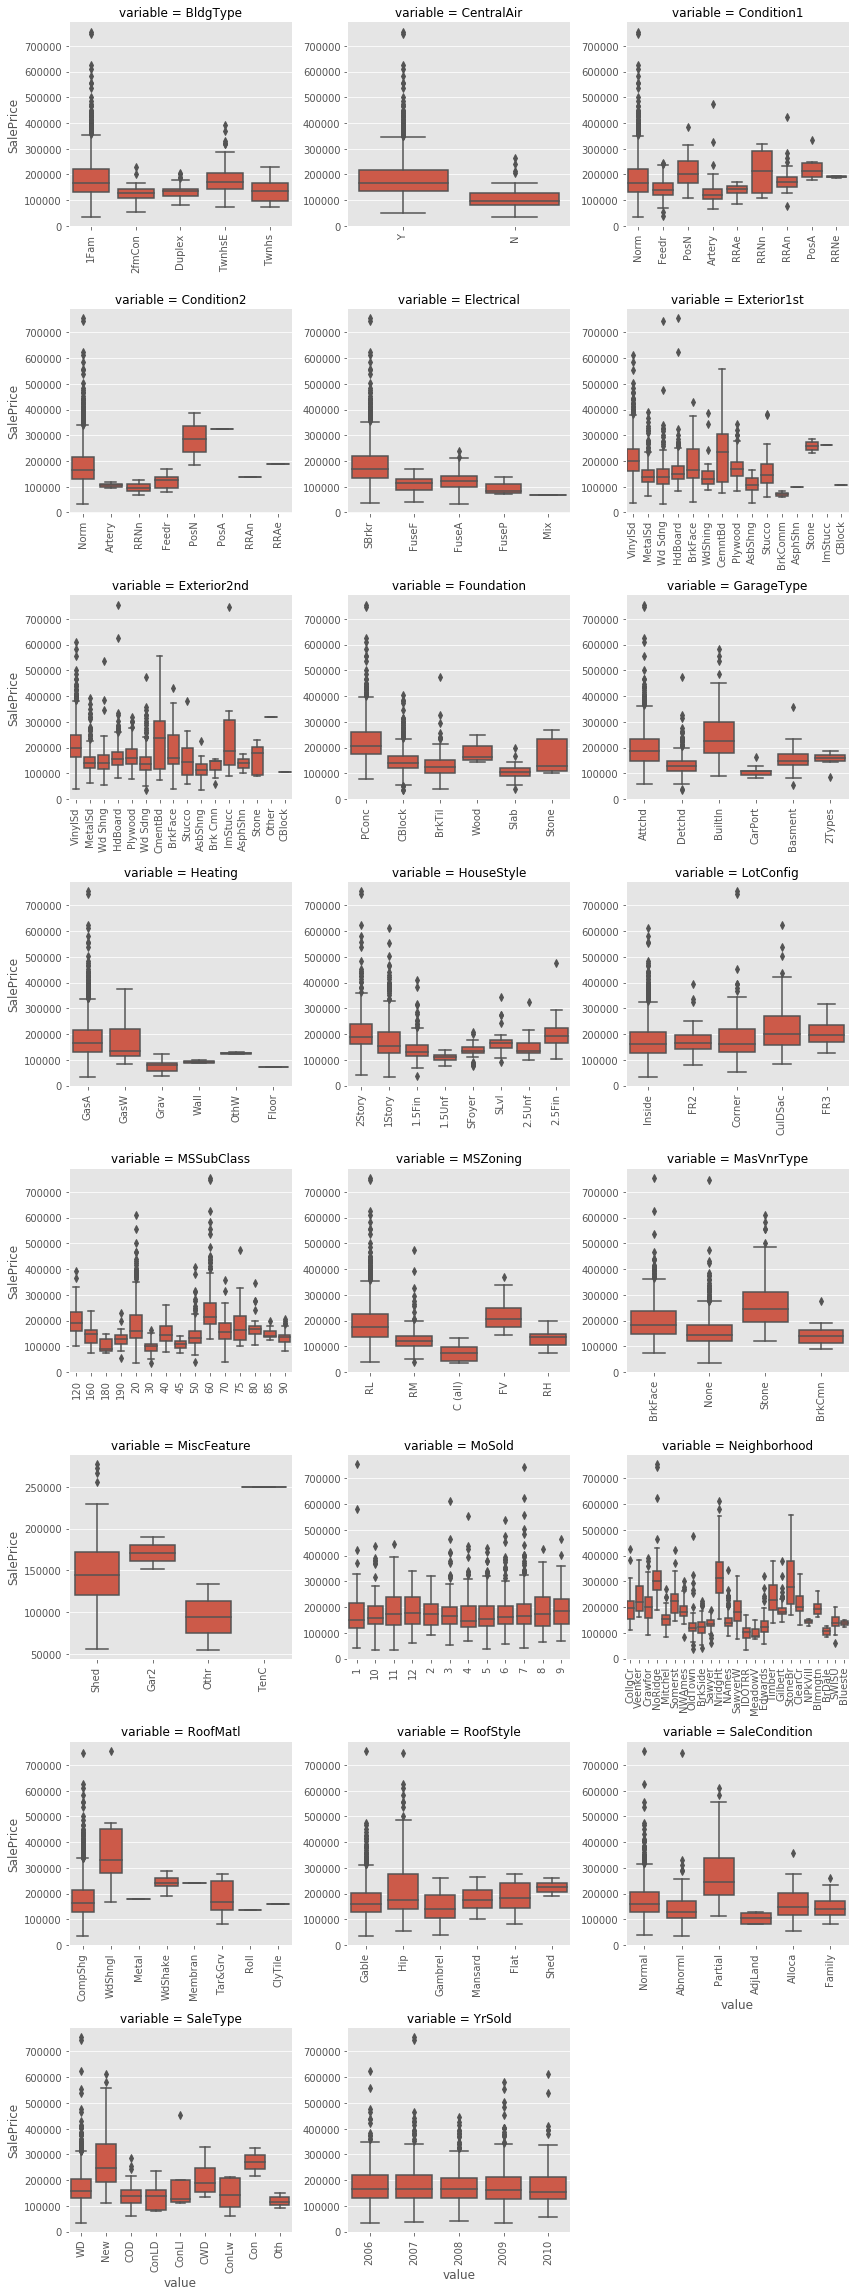

In [26]:



# Count plots of categorical features
f = pd.melt(train, id_vars=['SalePrice'], value_vars=sorted(cat_features))
g = sns.FacetGrid(f, col='variable', col_wrap=3, sharex=False, sharey=False, size=4)
g = g.map(sns.boxplot, 'value', 'SalePrice')
[plt.setp(ax.get_xticklabels(), rotation=90) for ax in g.axes.flat]
g.fig.tight_layout()
plt.show()



In [27]:
# In order for ANOVA to work, we have to take care of missing values first
train[cat_features] = train[cat_features].fillna('Missing')


In [28]:
# Onward...
anova = {'feature':[], 'f':[], 'p':[]}
for cat in cat_features:
    group_prices = []
    for group in train[cat].unique():
        group_prices.append(train[train[cat] == group]['SalePrice'].values)
    f, p = scipy.stats.f_oneway(*group_prices)
    anova['feature'].append(cat)
    anova['f'].append(f)
    anova['p'].append(p)
anova = pd.DataFrame(anova)
anova = anova[['feature','f','p']]
anova.sort_values('p', inplace=True)

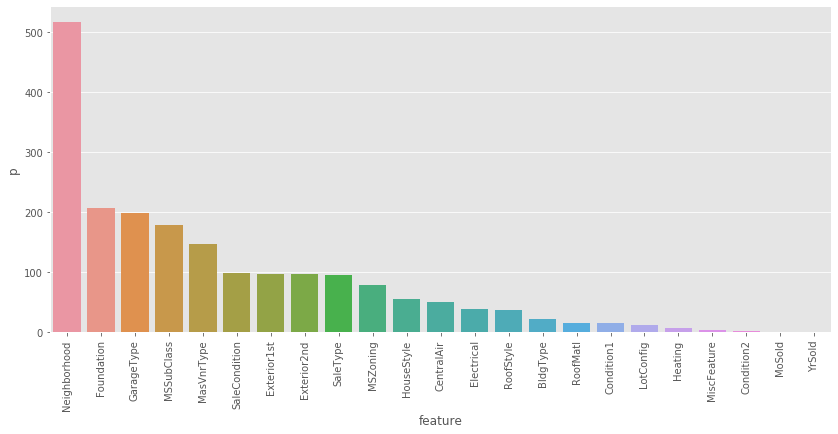

In [29]:
# Plot
plt.figure(figsize=(14,6))
sns.barplot(anova.feature, np.log(1./anova['p']))
plt.xticks(rotation=90)
plt.show()

/usr/local/anaconda3/lib/python3.7/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/anaconda3/lib/python3.7/site-packages/seaborn/categorical.py:3672: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


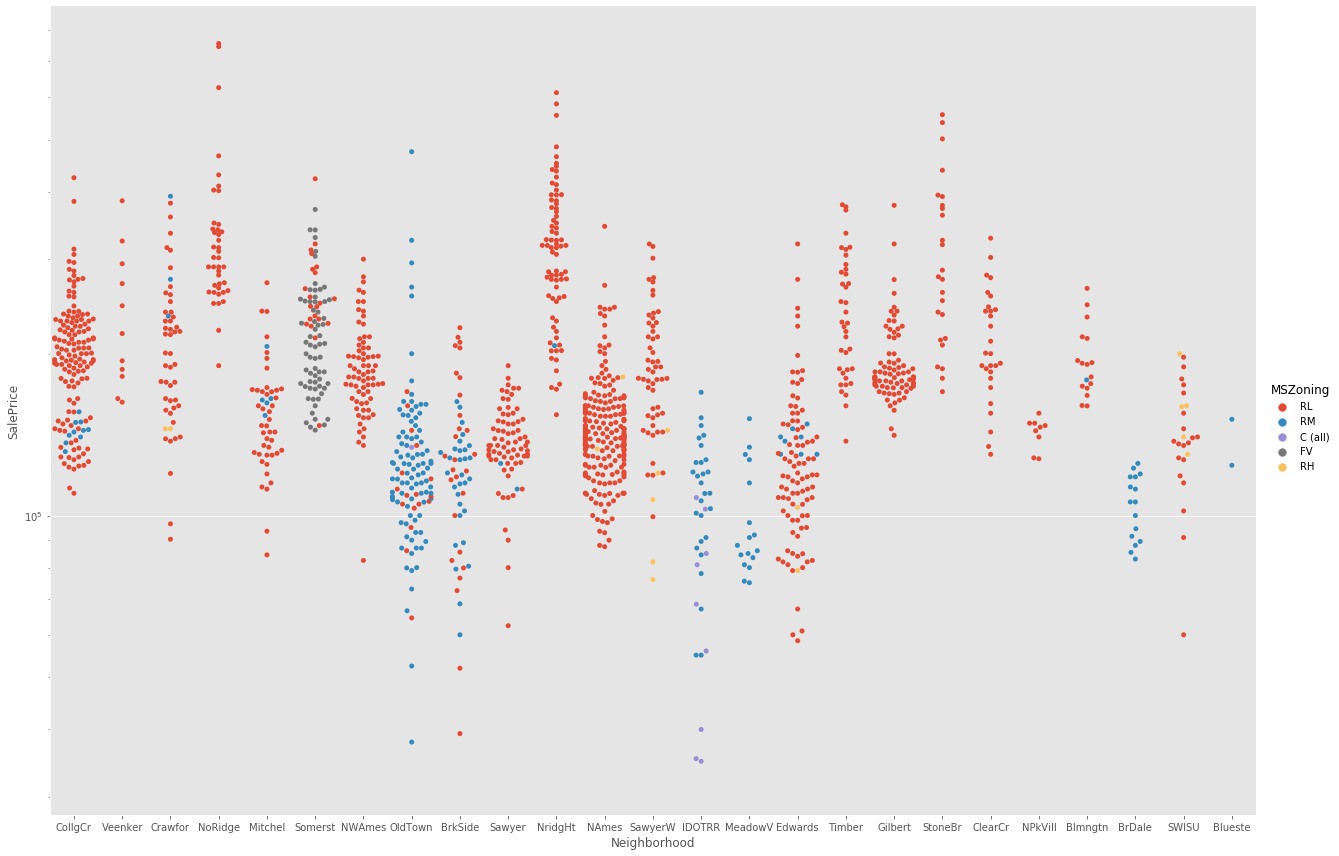

In [30]:
# Swarming Factorplot FTW
fig = sns.factorplot(x='Neighborhood', y='SalePrice', hue='MSZoning', data=train, kind='swarm', size=12, aspect=1.5)
ax = fig.axes[0][0]
ax.set_yscale('log')
plt.show()

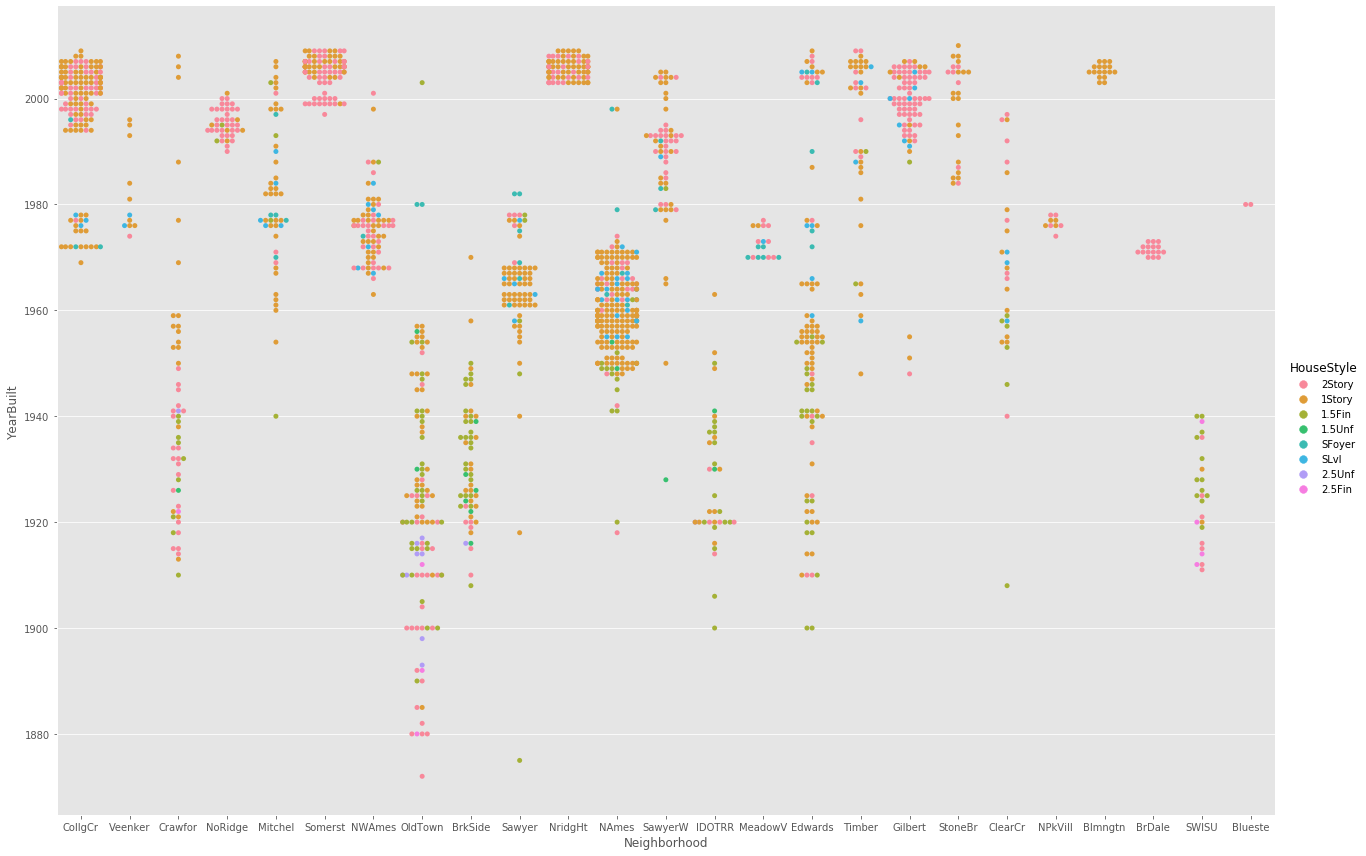

In [31]:
# Peering into the history of Ames, IA
fig = sns.factorplot(x='Neighborhood', y='YearBuilt', hue='HouseStyle', data=train, kind='swarm', size=12, aspect=1.5)
ax = fig.axes[0][0]
#ax.set_yscale('log')
#plt.show()

In [32]:
# Kaggle's not a fan of the code below
original_dataset = 'https://ww2.amstat.org/publications/jse/v19n3/decock/AmesHousing.txt'
og = pd.read_table(original_dataset)
print('There are {} duplicate observations'.format(og.PID.count() - og.PID.nunique()))

There are 0 duplicate observations


In [33]:


# Categorical features with "Missing" values
missing_values = (train[cat_features] == 'Missing').sum().sort_values(ascending=False)
missing_values[missing_values > 0]



MiscFeature    1406
GarageType       81
MasVnrType        8
Electrical        1
dtype: int64

In [34]:
# Since there's only one missing Electrical, let's
# set it equal to the most common type
train.loc[train.Electrical == 'Missing', 'Electrical'] = train.Electrical.mode()[0]

In [35]:
train.MasVnrType.value_counts()

None       864
BrkFace    445
Stone      128
BrkCmn      15
Missing      8
Name: MasVnrType, dtype: int64

In [36]:
train.MasVnrType.replace({'Missing':'None'}, inplace=True)

In [37]:
train.loc[(train.MasVnrType == 'None') & (train.MasVnrArea > 1), ['MasVnrType','MasVnrArea']]

,MasVnrType,MasVnrArea
624,None,288.0
1300,None,344.0
1334,None,312.0


In [38]:
train.loc[(train.MasVnrType != 'None') & (train.MasVnrArea == 0), ['MasVnrType','MasVnrArea']]

,MasVnrType,MasVnrArea
688,BrkFace,0.0
1241,Stone,0.0


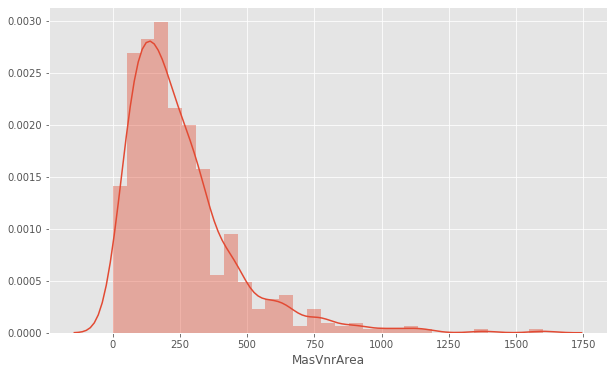

In [39]:
# Let's start with our dependent variable, SalePrice
plt.figure(figsize=(10,6))
sns.distplot(train.MasVnrArea.dropna()[train.MasVnrArea>0])
plt.show()

In [40]:
# We also notice a data discrepancy, we have 
# houses with MasVnrType == None but MasVnrArea > 0 and
# house with MasVnrArea == 0 but MasVnrType != None
# Let's fix these with the assumption that there was a mason veneer
train.loc[(train.MasVnrType == 'None') & (train.MasVnrArea > 1), 'MasVnrType'] = 'BrkFace' # most common 
train.loc[(train.MasVnrType == 'None') & (train.MasVnrArea == 1), 'MasVnrArea'] = 0 # 1 sq ft is basically 0
for vnr_type in train.MasVnrType.unique():
    # so here we set the area equal to the mean of the given veneer type
    train.loc[(train.MasVnrType == vnr_type) & (train.MasVnrArea == 0), 'MasVnrArea'] = \
        train[train.MasVnrType == vnr_type].MasVnrArea.mean() 

In [41]:
train.MasVnrArea

0       196.0
1         0.0
2       162.0
3         0.0
4       350.0
        ...  
1455      0.0
1456    119.0
1457      0.0
1458      0.0
1459      0.0
Name: MasVnrArea, Length: 1460, dtype: float64

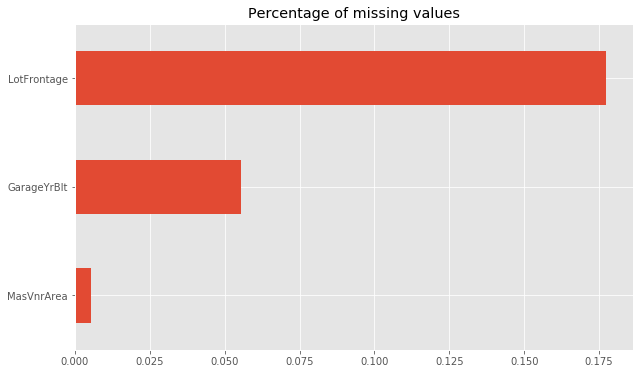

In [42]:
# Remaining missing values
missing_data = train.isnull().sum() / train.shape[0]
missing_data[missing_data > 0].\
    sort_values(ascending=True).\
    plot(kind='barh', figsize=(10,6))
plt.title('Percentage of missing values')
plt.show()

In [43]:


# LotFrontage is "Linear feet of street connected to property"
# Since it seems unlikely that there's no street connected
# to a lot, we'll set it equal to the median LotFrontage of that street.
train.LotFrontage = train.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))



In [44]:
# MasVnrArea is "Masonry veneer area in square feet"
# This feature consists of a majority of 0 values, so 
# it's odd to find missing values here. Let's set to 0
train.MasVnrArea.fillna(0, inplace=True)

In [45]:


# Since GarageYrBlt missing means there's no garage
# we'll set it equal to 0
train.GarageYrBlt.fillna(0, inplace=True)



In [46]:
# Anything left?
train.isnull().sum().sum()

0

In [64]:
train.to_csv('./data/train_clean.csv')

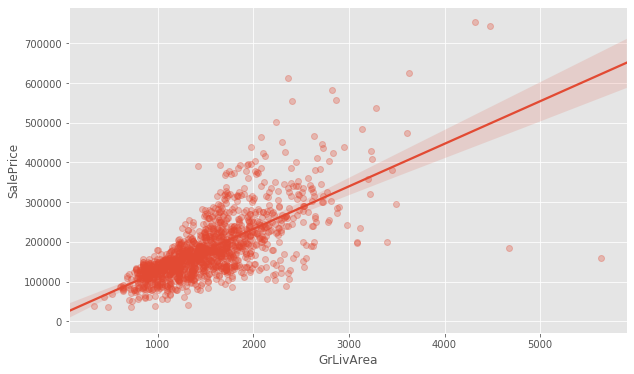

In [47]:

# First we visually inspect a scatter plot of GrLivArea vs. SalePrice
plt.figure(figsize=(10,6))
sns.regplot(train.GrLivArea, train.SalePrice, scatter_kws={'alpha':0.3})
plt.show()

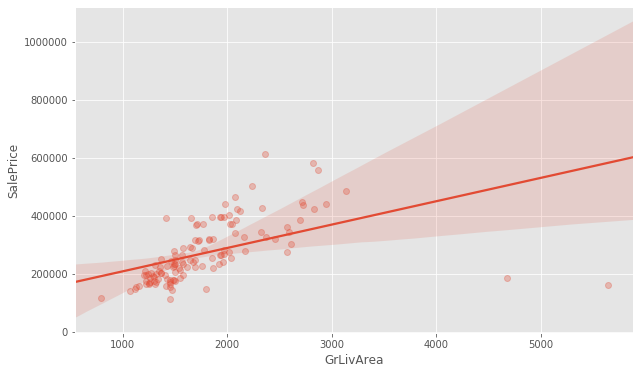

In [48]:
# We see the outliers but are also interested in those Partial Sale outliers
plt.figure(figsize=(10,6))
sns.regplot(train[train.SaleCondition == 'Partial'].GrLivArea,
            train[train.SaleCondition == 'Partial'].SalePrice, scatter_kws={'alpha':0.3})
plt.show()

In [49]:
# We heed the author's advice and cut out anything over 4,000 sq ft
train.drop(train[train.GrLivArea >= 4000].index, inplace=True)

In [50]:
train[['OpenPorchSF','EnclosedPorch','ScreenPorch','3SsnPorch']]

,OpenPorchSF,EnclosedPorch,ScreenPorch,3SsnPorch
0,61,0,0,0
1,0,0,0,0
2,42,0,0,0
3,35,272,0,0
4,84,0,0,0
...,...,...,...,...
1455,40,0,0,0
1456,0,0,0,0
1457,60,0,0,0
1458,0,112,0,0


In [51]:
# Let's add some additional features

# Total Square Footage
train['TotalSF'] = train.TotalBsmtSF + train.GrLivArea
train['TotalFloorSF'] = train['1stFlrSF'] + train['2ndFlrSF']
train['TotalPorchSF'] = train.OpenPorchSF + train.EnclosedPorch + \
    train['3SsnPorch'] + train.ScreenPorch
    
# Total Bathrooms
train['TotalBathrooms'] = train.FullBath + .5 * train.HalfBath + \
    train.BsmtFullBath + .5 * train.BsmtHalfBath

# Booleans
train['HasBasement'] = train.TotalBsmtSF.apply(lambda x: 1 if x > 0 else 0)
train['HasGarage'] = train.GarageArea.apply(lambda x: 1 if x > 0 else 0)
train['HasPorch'] = train.TotalPorchSF.apply(lambda x: 1 if x > 0 else 0)
train['HasPool'] = train.PoolArea.apply(lambda x: 1 if x > 0 else 0)
train['WasRemodeled'] = (train.YearRemodAdd != train.YearBuilt).astype(np.int64)
train['IsNew'] = (train.YearBuilt > 2000).astype(np.int64)
train['WasCompleted'] = (train.SaleCondition != 'Partial').astype(np.int64)

boolean_features = ['HasBasement', 'HasGarage', 'HasPorch', 'HasPool', 
                    'WasRemodeled', 'IsNew', 'WasCompleted']


In [52]:
num_features, cat_features = get_feature_groups()
num_features = [f for f in num_features if f not in boolean_features]

In [53]:
# Here we will be simplistic about it and simply
# log transform any numerical feature with a 
# skew greater than 0.5
features = num_features + ['SalePrice']
for f in features:
    train.loc[:,f] = np.log1p(train[f])

In [54]:
# before we continue, let's drop some cols
y = train['SalePrice']
train.drop('SalePrice', axis=1, inplace=True)
train.drop('Id', axis=1, inplace=True)

In [55]:


# ... and go
model_data = pd.get_dummies(train).copy()



In [56]:
model_data

,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LandSlope,OverallQual,OverallCond,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,4.189655,9.042040,1.098612,0.0,0.693147,1.609438,1.609438,1.386294,2.079442,1.791759,...,0,0,0,1,0,0,0,0,1,0
1,4.394449,9.169623,1.098612,0.0,0.693147,1.609438,1.609438,1.386294,1.945910,2.197225,...,0,0,0,1,0,0,0,0,1,0
2,4.234107,9.328212,1.098612,0.0,1.098612,1.609438,1.609438,1.386294,2.079442,1.791759,...,0,0,0,1,0,0,0,0,1,0
3,4.110874,9.164401,1.098612,0.0,1.098612,1.609438,1.609438,1.386294,2.079442,1.791759,...,0,0,0,1,1,0,0,0,0,0
4,4.442651,9.565284,1.098612,0.0,1.098612,1.609438,1.609438,1.386294,2.197225,1.791759,...,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,4.143135,8.976894,1.098612,0.0,0.693147,1.609438,1.609438,1.386294,1.945910,1.791759,...,0,0,0,1,0,0,0,0,1,0
1456,4.454347,9.486152,1.098612,0.0,0.693147,1.609438,1.609438,1.386294,1.945910,1.945910,...,0,0,0,1,0,0,0,0,1,0
1457,4.204693,9.109746,1.098612,0.0,0.693147,1.609438,1.609438,1.386294,2.079442,2.302585,...,0,0,0,1,0,0,0,0,1,0
1458,4.234107,9.181735,1.098612,0.0,0.693147,1.609438,1.609438,1.386294,1.791759,1.945910,...,0,0,0,1,0,0,0,0,1,0


In [57]:
num_features


['LotFrontage',
 'LotArea',
 'Street',
 'Alley',
 'LotShape',
 'LandContour',
 'Utilities',
 'LandSlope',
 'OverallQual',
 'OverallCond',
 'YearBuilt',
 'YearRemodAdd',
 'MasVnrArea',
 'ExterQual',
 'ExterCond',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinSF1',
 'BsmtFinType2',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 'HeatingQC',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'KitchenQual',
 'TotRmsAbvGrd',
 'Functional',
 'Fireplaces',
 'FireplaceQu',
 'GarageYrBlt',
 'GarageFinish',
 'GarageCars',
 'GarageArea',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'PoolQC',
 'Fence',
 'MiscVal',
 'TotalSF',
 'TotalFloorSF',
 'TotalPorchSF',
 'TotalBathrooms']

In [63]:
train.to_csv('./data/train_clean.csv')

In [60]:
train['SalePrice']

KeyError: 'SalePrice'

In [61]:
train['SalePrice'] = y

In [62]:
train['SalePrice']

0       12.247699
1       12.109016
2       12.317171
3       11.849405
4       12.429220
          ...    
1455    12.072547
1456    12.254868
1457    12.493133
1458    11.864469
1459    11.901590
Name: SalePrice, Length: 1456, dtype: float64